In [ ]:
# 準備
# URL先からファイルのインストール
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

In [ ]:
# 準備
# zipファイルの解凍
!unzip NewsAggregatorDataset.zip

In [5]:
# 50. データの入手・整形
# csvファイルを扱うのでpandasをインポートする
import pandas as pd
# データ分割を行うためにscikit-learnのtrain_test_splitをインポートする
from sklearn.model_selection import train_test_split

# データを読込む
# haderは無し,区切り文字は'\t'
# 取得したreadme.txtに書いてあるものをnamesとする
df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データを抽出する
# pandasのisinを用いてpublisherが"Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを選択し
# pandasのlocでtitle,categoryの項目のみをを抽出する（条件がカテゴリ名と記事見出しであるので）
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データを分割する
# train_test_splitを用いる
# まず8:2に分割するのでtestsize=0.2にしておく(trainが8でvaild_testが2)
# デフォルトでシャッフルされるようになっている。またシード値はrandom_stateで固定しておく(毎回同じようにシャッフルされるように)
# 学習のためにカテゴリの事例数に偏りがないようにstratifyでcategoryを指定する# 
train, valid_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['CATEGORY'])
# さらにvalid_testを1：1で分割してそれぞれ10％ずつの検証データと評価データにする
valid, test = train_test_split(valid_test, test_size=0.5, random_state=0, stratify=valid_test['CATEGORY'])

# データを保存する
# 今回txtファイルとして保存する必要があるが、pandasはto_txtなどのオプションがないようなので、前回と同じくto_csvを用います(すみません)
# タブ区切り、ヘッダーはあるので、indexのみfalse
train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

# 事例数の確認
# pandasのvalue_counts()で要素の値をindex、出現個数をdataとして返す
print('学習データ\n', train['CATEGORY'].value_counts())
print('検証データ\n', valid['CATEGORY'].value_counts())
print('評価データ\n', test['CATEGORY'].value_counts())

学習データ
 b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
 b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
 b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [6]:
# 51. 特徴量抽出
# カテゴリごとに分類することが目標であるカテゴリ分類問題のため
# 特徴量は記事見出しの特徴的な単語とする
# TF-IDFで重み付けをして特徴量の抽出を行う

# sklearnのTfidfVectorizerを用いてTF-IDFを実装する
from sklearn.feature_extraction.text import TfidfVectorizer
# 記号などをまとめてstring.punctuationで扱うのでstringをインポート
import string

# TF-IDFの実装のため前処理の関数
def adjust(text):
  # 文の整理を行う
  # translate()を用いて記号(string.punctuation)を削除
  # maketrans()の第三引数に与えることで、その単語をNoneに置換する
  text = text.translate(str.maketrans('', '', string.punctuation))
  # lower()ですべてを小文字に
  text = text.lower() 
  return text

# TF-IDFを訓練、検証、テストセットごとに行うとそれぞれ単語の数(ベクトルの次元)が異なってしまう
# したがって、再度データを縦に連結しなおす
redf = pd.concat([train, valid, test], axis=0)
# 連結しなおしたものにreset_indexでindexを振りなおす(後でもう一度分割するため)
redf.reset_index(drop=True, inplace=True)  

# 前処理を施す
# map()とlambdaを用いて関数を適用する
redf['TITLE'] = redf['TITLE'].map(lambda x: adjust(x))

# TF-IDFの実装
# TfidfVectorizerのパラメータでTF-IDFの設定を変更可能
# min_dfで単語の使用されている文書割合(0~1)または単語の使用されている文書数(整数)以下の単語を排除する
# ngram_rangeでn-gramの範囲を指定する(カテゴリ分類の場合には1-gram、2-gramを用いることが有効なので今回は1,2)
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))  

# 上で作ったredf['TITLE']にtfidfを適用
dfx = tfidf.fit_transform(redf['TITLE'])

# 結果をデータフレームに変更columnsはn-gramの要素
dfx = pd.DataFrame(dfx.toarray(), columns=tfidf.get_feature_names())

# データフレームを訓練、検証、テストに再度分割する
# 50で作成したセットの長さを利用する
# まず訓練、検証セットとテストセットに分ける
df_train_valid = dfx[:len(train) + len(valid)]
df_test = dfx[len(train) + len(valid):]
# 訓練セット、検証セットに分ける
df_train = df_train_valid[:len(train)]
df_valid = df_train_valid[len(train):]

# それぞれxxx.feature.txtに保存する
df_train.to_csv('train.feature.txt', sep='\t', index=False)
df_valid.to_csv('valid.feature.txt', sep='\t', index=False)
df_test.to_csv('test.feature.txt', sep='\t', index=False)

# 確認用に訓練とテストの特徴抽出を表示
print(df_train)
print(df_test)


        10  10 billion  100  10year   11  ...  yuan  zac  zac efron  zendaya  zone
0      0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
1      0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
2      0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
3      0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
4      0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
...    ...         ...  ...     ...  ...  ...   ...  ...        ...      ...   ...
10667  0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
10668  0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
10669  0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
10670  0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
10671  0.0         0.0  0.0     0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0

[10

In [7]:
# 52. 学習
# sklearnのLogisticRegressionを用いてロジスティック回帰モデルの学習を行う
from sklearn.linear_model import LogisticRegression

# モデルの学習
# LogisticRegressionでモデルのインスタンスの生成
# シード値を指定して、モデルの再現性を担保しておく
lg = LogisticRegression()
# fit()メソッドに特徴量とターゲットの訓練データ（今回はtrain['CATEGORY'])を与えて学習させる
lg.fit(df_train, train['CATEGORY'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# 53. 予測
import numpy as np

# 予測確率とカテゴリを計算するための関数
# 引数は上で作成したロジスティック関数によるモデルと、入力データ
def pre_score(lg, x):
  # LogisticRegressionのpredict_proba()で予測確率を、predict()で予測ラベルを返す
  # 予測確率をのうち最大のものをとるためにnumpy.amax()を使用する.axis=1で範囲を配列の横に指定
  return [np.amax(lg.predict_proba(x), axis=1), lg.predict(x)]

# 54で訓練とテストのデータを用いるので、それらの予測をしておく
train_pred = pre_score(lg, df_train)
test_pred = pre_score(lg, df_test)
# 確認
print(train_pred)
print(test_pred)

[array([0.4786736 , 0.92427677, 0.62277342, ..., 0.89877999, 0.96177121,
       0.65314832]), array(['b', 'b', 'e', ..., 'b', 'b', 'e'], dtype=object)]
[array([0.84861374, 0.67782683, 0.98066116, ..., 0.38783556, 0.80322441,
       0.93488536]), array(['e', 'b', 'e', ..., 't', 't', 'b'], dtype=object)]


In [9]:
# 54. 正解率の計測
# sklearnのaccuracy_scoreを用いて正解率を求める
# 予測ラベルは53で作成したものを用いる
from sklearn.metrics import accuracy_score
print('学習データ：',accuracy_score(train['CATEGORY'], train_pred[1]))
print('評価データ：', accuracy_score(test['CATEGORY'], test_pred[1]))

学習データ： 0.9236319340329835
評価データ： 0.8740629685157422


In [10]:
# 55. 混同行列の作成
# sklearnのconfusion_matrixを用いて混合行列を作成する
from sklearn.metrics import confusion_matrix

# 混同行列のラベル順を指定するためのリストを作成(50で確認したものと同じ順にする)
label_name = ['b','e','t','m']
# columns(予測ラベル),index（正解ラベル)用のラベルを作成する
columns_label = ['pred_b','pred_e','pred_t','pred_m']
index_label = ['act_b','act_e','act_t','act_m']


print('学習データ')
# confusion_matrixで混合行列を作成し、それをデータフレームに直す
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1], labels = label_name)
print(pd.DataFrame(train_cm, columns=columns_label, index=index_label))
print('\n評価データ')
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1], labels=label_name)
print(pd.DataFrame(test_cm, columns=columns_label, index=index_label))

学習データ
       pred_b  pred_e  pred_t  pred_m
act_b    4362      86      45       9
act_e      45    4165      10       3
act_t     222     144     847       6
act_m     102     126      17     483

評価データ
       pred_b  pred_e  pred_t  pred_m
act_b     527      25      10       1
act_e      14     510       1       3
act_t      46      22      82       2
act_m      20      20       4      47


In [11]:
# 56. 適合率，再現率，F1スコアの計測
# 同じくsklearnからインポートする
from sklearn.metrics import precision_score, recall_score, f1_score

# 計測のための関数
def measure(y_true, y_pred):
  # precision_scoreで適合率を求める
  # average=Noneでそれぞれのクラスごとに値を求められる。クラスの順番は55で作成したラベルの順。
  # これはnumpy.ndarrayの型で返される
  precision = precision_score(y_true, y_pred, average=None, labels=label_name)  
  # averageをmicroにしておくとマイクロ平均、macroにするとマクロ平均が求められる
  # 後でデータフレームに直すのでnp.appendで結合しておく
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # recall_scoreで再現率を同じく求める
  recall = recall_score(y_true, y_pred, average=None, labels=label_name)
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # f1_scoreでF1スコアも同じく求める
  f1 = f1_score(y_true, y_pred, average=None, labels=label_name)
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # データフレームに直す
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])
  # データフレームを返す
  return scores

# 確認
print(measure(test['CATEGORY'], test_pred[1]))

             適合率       再現率     F1スコア
b       0.868204  0.936057  0.900855
e       0.883882  0.965909  0.923077
t       0.845361  0.539474  0.658635
m       0.886792  0.516484  0.652778
マイクロ平均  0.874063  0.874063  0.874063
マクロ平均   0.871060  0.739481  0.783836


In [12]:
# 57. 特徴量の重みの確認

# まず特徴量の名前（1-gram,2-gram単語名)を取得する
features_label = df_train.columns.values
# top10の順位付けのためのインデックス
number_label = [i for i in range(1, 11)]

# それぞれのクラスごとに特徴量を確認する
# クラスはclasses_ . 特徴量の値はcoef_で取得できる(zipでまとめて取得)
for c, coef in zip(lg.classes_, lg.coef_):

  # top10の取得(データフレームに直す)
  # np.argsortで要素の値順に並び替えたインデックスのndarrayを返す([::-1]で降順)
  # そこからトップ10までのインデックスに対応する特徴量のラベルを取得する
  top10 = pd.DataFrame(features_label[np.argsort(coef)[::-1][:10]], columns=['top10'], index=number_label)
  # worst10も同じように
  worst10 = pd.DataFrame(features_label[np.argsort(coef)[:10]], columns=['worst10'], index=number_label)

  # 表示
  print('クラス:', c)
  # top10とworst10をpd.concat()で結合する。横に連結するのでaxis=1
  print(pd.concat([top10, worst10], axis=1),'\n')

クラス: b
        top10    worst10
1         fed      video
2        bank        the
3         ecb        and
4     ukraine        her
5      stocks      ebola
6         oil       this
7        euro  microsoft
8   obamacare   facebook
9       china    tmobile
10     profit      heart 

クラス: e
         top10 worst10
1        chris  update
2   kardashian      us
3          her  google
4        movie   study
5         film     ceo
6          kim   china
7      wedding    says
8         paul      gm
9          she     may
10        star    data 

クラス: m
      top10   worst10
1     ebola        gm
2     study      deal
3    cancer      bank
4      mers       ceo
5       fda  facebook
6      drug     sales
7   medical   climate
8    health     apple
9     cases      cars
10    heart   twitter 

クラス: t
         top10  worst10
1       google   shares
2     facebook   cancer
3        apple      fed
4      climate   stocks
5    microsoft      her
6      tmobile     drug
7           gm  ukraine
8   

In [13]:
# 58. 正則化パラメータの変更

# グラフ表示のためのリスト
# パラメータ
result_c = []
# 訓練データの正解率
result_train = []
# 検証データの正解率
result_valid = []
# テストデータの正解率
result_test = []

# 正規化パラメータの値を対数スケールで10^-4から10^4までとる
# (どの程度の値で変化させるのが適切なのでしょうか?)
# numpy.logspaceで対数スケールの配列を作成(開始、終了、要素数、基底)
c_params = np.logspace(-4, 4, 8, base=10)

# それぞれのパラメータで学習を行う
for c in c_params:
  result_c.append(c)

  # 52同様にモデルの学習を行う
  # 比較を行うので、random_state=0とシード値指定する
  lg = LogisticRegression(random_state=0, C=c)
  lg.fit(df_train, train['CATEGORY'])

  # 今回は正解率だけ(予測確率は求めない)ので53で作成したものは使わない
  # lg.predictで予測ラベルを求め、それとaccuracy_scoreを用いて正解率を求めリストに格納
  result_train.append(accuracy_score(train['CATEGORY'], lg.predict(df_train)))
  result_valid.append(accuracy_score(valid['CATEGORY'], lg.predict(df_valid))) 
  result_test.append(accuracy_score(test['CATEGORY'], lg.predict(df_test))) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


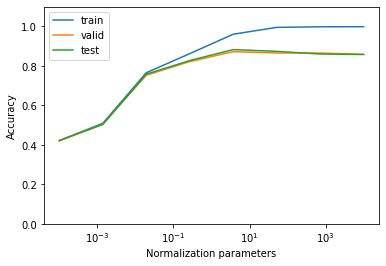

In [14]:
# 58. 正則化パラメータの変更
# グラフの表示
import matplotlib.pyplot as plt
# それぞれのデータのグラフの作成
plt.plot(result_c, result_train, label='train')
plt.plot(result_c, result_valid, label='valid')
plt.plot(result_c, result_test, label='test')
# y軸の設定
# ylimの範囲をこのように指定するとうまく表示できる
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
# x軸は対数
plt.xscale ('log')
plt.xlabel('Normalization parameters')
# 凡例の表示をlegend()で行う
plt.legend()
plt.show()

In [ ]:
# 59. ハイパーパラメータの探索
# サーチ方法としてグリッドサーチとランダムサーチを用いる
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# ハイパーパラメータの候補を作成する
# パラメータは正規化パラメータ,random_state,と探索回数(max_iter)
# (本当はもっと多く候補を試していたのですが、）
# (計測時間があまりにも長くなってしまったので、減らしました)
# (本来の目的から外れていると思います。すみません。)
params = {LogisticRegression(): {"C": [i for i in range(5, 11)],  
                                  "max_iter": list(range(100, 301, 100))}}
# 検証データのスコア
gscv_score = 0
rscv_score = 0
# テストデータのスコア
test_score = 0
# サーチメソッドの判定に使用する変数
SearchMethod = 0

# 作成したパラメータを用いて探索を行う
# まずグリッドサーチから行う
# for文を用いているのは上で作成したパラメータからmodelとparamを取得するため
for model, param in params.items():
  # グリッドサーチのインスタンスを作成
  gscv = GridSearchCV(model, param)
  # 学習を開始
  gscv.fit(df_train, train['CATEGORY'])
  # best_estimator_でグリッドサーチの中で最も精度が高いパラメータで学習した分類器を取得
  gscv_estimator = gscv.best_estimator_
  # それを用いて検証データ上の正解率を求める
  gscv_score = accuracy_score(valid['CATEGORY'], gscv_estimator.predict(df_valid))

# 次にランダムサーチを行う
# 手順はグリッドサーチと同じなので説明は割愛
for model, param in params.items():
  rscv =RandomizedSearchCV(model, param)
  rscv.fit(df_train, train['CATEGORY'])
  rscv_estimator = rscv.best_estimator_
  rscv_score = accuracy_score(valid['CATEGORY'], rscv_estimator.predict(df_valid))

In [16]:
# 59. ハイパーパラメータの探索
# スコアの表示

#上で作成したグリッドサーチとランダムサーチの検証データ上の正解率を比較する 
if gscv_score > rscv_score:
  # グリッドサーチの方が高ければ、グリッドサーチの最も精度が高い分類器を用いて評価データ上の正解率を求める
  test_score = accuracy_score(test['CATEGORY'], gscv_estimator.predict(df_test))
  # 結果と用いたパラメータの表示
  print("評価データの正解率", test_score)
  print("サーチ方法:グリッドサーチ")
  print("モデル:LogisticRegression()")
  print("パラメーター:", gscv.best_params_)

else:
  # ランダムサーチの方が高い場合も同様に行う
  test_score = accuracy_score(test['CATEGORY'], rscv_estimator.predict(df_test))
  print("評価データの正解率", test_score)
  print("サーチ方法:ランダムサーチ")
  print("モデル:LogisticRegression()")
  print("パラメーター:", rscv.best_params_)

評価データの正解率 0.8823088455772113
サーチ方法:ランダムサーチ
モデル:LogisticRegression()
パラメーター: {'max_iter': 100, 'C': 5}


In [17]:
# 54で求めた正解率より高くなっている
print('評価データ：', accuracy_score(test['CATEGORY'], test_pred[1]))

評価データ： 0.8740629685157422
